In [42]:
import json
from networkx.readwrite import json_graph
import re
import pickle
import mowl
mowl.init_jvm("4g")
import networkx as nx
import matplotlib.pyplot as plt

First we have to read the ontology graph

In [2]:
Onto_graph_raw = []
with (open("../../Data/Input/Graph_mesh_OWL2VEC.pkl", "rb")) as openfile:
    while True:
        try:
            Onto_graph_raw.append(pickle.load(openfile))
        except EOFError:
            break

Here we are formatting the information of the projected graph in a more efficient data structure.

In [3]:

id2idx = {}
idx_ref = -1

# A weird term is a term that not complies with the MeSH format of ids, MeSH_id examples = "D007484", "T083", "Q000266"
def findWeirTerm(term, dict):
    if(len(re.findall("[A-Z]+[0-9]+", term)) == 0):
        if(term in dict): dict[term] += 1
        else: dict[term] = 1
    return dict

def getIdx(id):
    if(id in id2idx):
        return id2idx[id]
    else:
        global idx_ref
        idx_ref+=1
        id2idx[id] = idx_ref
        id2idx[idx_ref] = id
        
        return idx_ref

def format_Big(raw_graph):
    v = 0
    new_G = nx.DiGraph()
    weird_terms = {}
    for section in raw_graph:
        for edge in section:
            # print(edge.src)
            src = edge.src.split("/")[-1]
            rel = edge.rel.split("/")[-1]
            dst = edge.dst.split("/")[-1]
            
            weird_terms = findWeirTerm(src,weird_terms)
            weird_terms = findWeirTerm(dst,weird_terms)
            
            if(rel == "superclassof"):
                new_G.add_edge(getIdx(src),getIdx(dst))
    
    print(weird_terms)
    return new_G

big_G = format_Big(Onto_graph_raw)

{'owl#Thing': 236, 'core#OrderedCollection': 3, 'core#Collection': 2, '22-rdf-syntax-ns#List': 1, 'core#Concept': 12, 'core#ConceptScheme': 4}


## Visualize part of the graph

I think the root of the tree is owl#Thing, we want to create the bfs tree from the root and assign a lvl to the nodes that we find on the way.

In [12]:
def dfs_tree_from(source_node):
    tree = nx.bfs_tree(big_G, source=id2idx[source_node], depth_limit=1)
    print(id2idx[source_node],len(tree))
    nx.draw_spring(tree,with_labels = True)

393


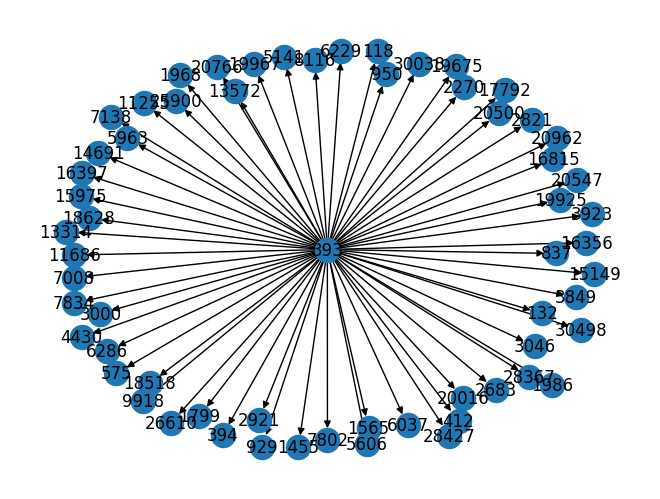

In [8]:
dfs_tree_from("D013514")

696 119


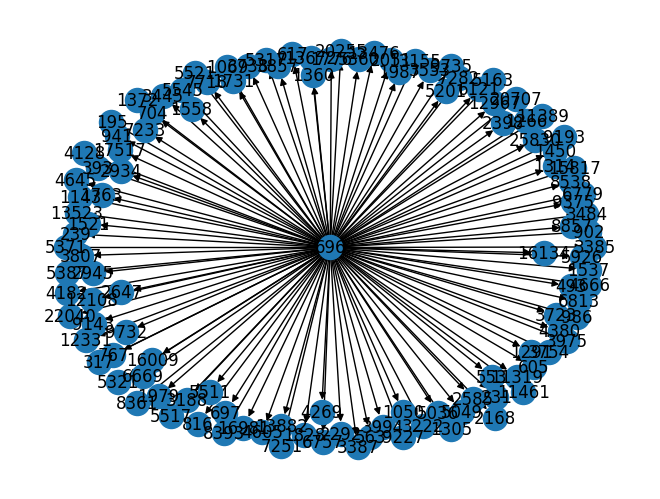

In [13]:
dfs_tree_from("owl#Thing")

We want to check wich node has no predecesors, thus becoming the root

In [30]:
print(nx.is_tree(big_G))
print(nx.is_forest(big_G))
print(nx.is_branching(big_G))

False
False
False


In [29]:
node = id2idx["owl#Thing"]    
print(node,id2idx[node])
ancestor = nx.bfs_successors(big_G, source=node, depth_limit=1)
for lst in ancestor:
    # print(lst)
    for elem in lst[1]:
        print(id2idx[elem])

696 owl#Thing
(696, [697, 1731, 2051, 2292, 2585, 4269, 5926, 1360, 6121, 3553, 1314, 6757, 6779, 5036, 902, 2398, 563, 6669, 7718, 3387, 1266, 9375, 13672, 11389, 617, 9143, 13523, 5360, 3754, 16009, 5511, 2168, 9735, 605, 13476, 8538, 16981, 1979, 195, 9732, 1521, 4128, 1828, 7251, 1558, 5521, 3222, 239, 5545, 8857, 8393, 941, 11319, 17517, 5371, 493, 393, 816, 12331, 5317, 12108, 9193, 2945, 22040, 4645, 1537, 15817, 7233, 3807, 1763, 13155, 1776, 3484, 3857, 12967, 5517, 5201, 2647, 1987, 1305, 8361, 16134, 5321, 1450, 1143, 317, 4605, 20707, 25830, 3385, 5163, 231, 3723, 7282, 704, 6813, 9227, 1291, 4666, 11461, 13882, 2934, 3738, 1069, 3445, 553, 1050, 3188, 20255, 1372, 3975, 3994, 4182, 5049, 4380, 767, 5387, 986])
D006730
D004703
D008055
D055827
D004700
U000018
D001105
D008919
U000016
D004472
D004628
U000017
D020164
D006809
D002468
D004864
D006281
D009358
D004493
D006802
D007287
D010829
D004778
D000091642
D013812
D009420
D017530
D013568
D001520
D017437
D018514
D009422
D012101


Once we find the root of the tree, we can use 
```
    nx.descendants_at_distance(G, source, distance)
```
or
```
    nx.bfs_layers(G, sources)
```
To determine the depth of the nodes and create our input file, for the next layer

In [36]:
node_depth = {}
layers = nx.bfs_layers(big_G,id2idx['owl#Thing'])
layers_dict = dict(enumerate(layers))
for k,v in layers_dict.items():
    print("Depth",k)
    for node in v:
        node_depth[node] = k
# print(node_depth)

Now lets add a property to each node representing the depth they have.

In [41]:
nx.set_node_attributes(big_G, node_depth, "Depth")
print(big_G.nodes[5360]["Depth"])

1


Now the last step is to save the graph with its respectives depths.

In [46]:
# print(json_graph.node_link_data(big_G))
with open("../../Data/Output/MeSH_graph_with_depth.json", "w") as fp:
            json.dump(json_graph.node_link_data(big_G),fp,indent = 2) 

{'directed': True, 'multigraph': False, 'graph': {}, 'nodes': [{'Depth': 3, 'id': 0}, {'Depth': 4, 'id': 1}, {'Depth': 4, 'id': 2}, {'Depth': 5, 'id': 3}, {'Depth': 4, 'id': 4}, {'Depth': 4, 'id': 5}, {'Depth': 4, 'id': 6}, {'Depth': 4, 'id': 7}, {'Depth': 6, 'id': 8}, {'Depth': 6, 'id': 9}, {'Depth': 4, 'id': 10}, {'Depth': 5, 'id': 11}, {'Depth': 2, 'id': 12}, {'Depth': 3, 'id': 13}, {'Depth': 3, 'id': 14}, {'Depth': 4, 'id': 15}, {'Depth': 3, 'id': 16}, {'Depth': 3, 'id': 17}, {'Depth': 3, 'id': 18}, {'Depth': 4, 'id': 19}, {'Depth': 3, 'id': 20}, {'Depth': 4, 'id': 21}, {'Depth': 3, 'id': 22}, {'Depth': 3, 'id': 23}, {'Depth': 6, 'id': 24}, {'Depth': 7, 'id': 25}, {'Depth': 4, 'id': 26}, {'Depth': 5, 'id': 27}, {'Depth': 6, 'id': 28}, {'Depth': 7, 'id': 29}, {'Depth': 4, 'id': 30}, {'Depth': 5, 'id': 31}, {'Depth': 4, 'id': 32}, {'Depth': 5, 'id': 33}, {'Depth': 3, 'id': 34}, {'Depth': 3, 'id': 35}, {'Depth': 2, 'id': 36}, {'Depth': 3, 'id': 37}, {'Depth': 4, 'id': 38}, {'Depth': 5